# 🤖 Modèles Classiques Supervisés – Comparaison & Interprétation

Ce notebook compare plusieurs modèles de classification supervisée sur les features extraites des sons :

- SVM
- Random Forest
- K-Nearest Neighbors
- XGBoost

Nous utilisons :
- des features extraites avec `librosa` (MFCC, Mel, etc.)
- des labels (`y`) disponibles sur les données validées

Enfin, nous interprétons les résultats avec :
- `LIME` : interprétation locale
- `SHAP` : importance globale des features

📌 Les features utilisées sont les moyennes par fichier : `X_mean`


!pip install xgboost

!pip install xgboost shap lime

In [1]:
# 📌 Librairies standards
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import shap
import lime
import lime.lime_tabular

# 📌 Configuration globale
import warnings
warnings.filterwarnings('ignore')

# 📂 Ajout dynamique du répertoire principal au PYTHONPATH
project_root = Path.cwd().parent  # DCASE2024_ASD_Project/
sys.path.append(str(project_root))

# 🔧 Projet
from src import config, processing
from src.utils.logger_utils import logger


## 📌 1️⃣ Chargement des Features Audio
Cette fonction charge les features normalisés `.npy` et les labels correspondants.

In [3]:
# 📦 Chargement des features extraites
X, y, df_meta = processing.load_audio_features(config.FEATURES_DIR, flatten=True, scaler=StandardScaler())

# 📊 Vérification des tailles
#logger.info(f"✅ Données chargées avec succès : {X.shape[0]} échantillons, {X.shape[1]} features")
#logger.info(f"✅ Label chargées avec succès : {y.shape[0]} échantillons, {y.shape[1]} features")

Loading mel+other: 100%|██████████████████████████████████████████████████████| 61974/61974 [03:55<00:00, 262.85file/s]


## ✂️ 2️⃣ Séparation Train/Test
Sépare les données pour l'entraînement et le test.

In [6]:
# ⚖️ Train/test split (stratifié)
X_train, X_test, y_train, y_test = processing.split_train_test(X, y, test_size=0.2)

# 📊 Vérification des tailles
print(f"📊 Répartition : {X_train.shape[0]} train, {X_test.shape[0]} test")


In [7]:
# 🔄 Reformater X_train et X_test en (n_samples, n_features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

✅ Pourquoi ?

* On charge les features directement depuis les fichiers .npy.
* On standardise les données (StandardScaler) pour que les modèles soient plus stables.
* On sépare en train et test pour évaluer les performances.

## 🧠 3️⃣ – Entraînement des Modèles Classiques et Évaluation

Nous entraînons 4 modèles supervisés sur les features audio :

- SVM (Support Vector Machine)
- Random Forest (rf)
- K-Nearest Neighbors (KNN)
- XGBoost (Gradient Boosting)

Chaque modèle est évalué avec :
- Accuracy
- F1-score
- AUC
- Matrice de confusion


2025-03-22 23:57:01 - INFO - 🚀 Entraînement du modèle : SVM
2025-03-23 00:39:28 - INFO - 
              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90      5104
     Anomaly       1.00      0.00      0.00      1094

    accuracy                           0.82      6198
   macro avg       0.91      0.50      0.45      6198
weighted avg       0.85      0.82      0.74      6198



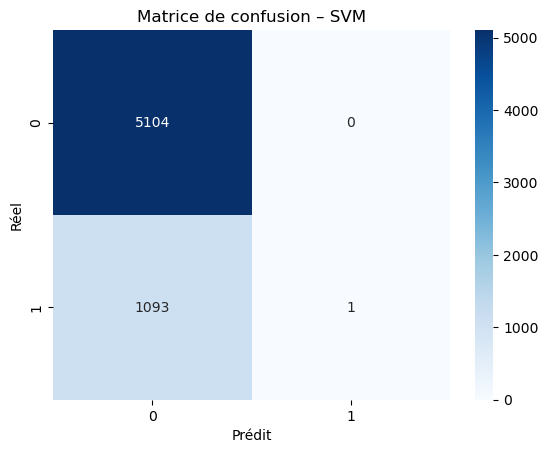

2025-03-23 00:39:28 - INFO - 🚀 Entraînement du modèle : RandomForest
2025-03-23 00:40:06 - INFO - 
              precision    recall  f1-score   support

      Normal       0.83      1.00      0.91      5104
     Anomaly       0.96      0.02      0.05      1094

    accuracy                           0.83      6198
   macro avg       0.90      0.51      0.48      6198
weighted avg       0.85      0.83      0.75      6198



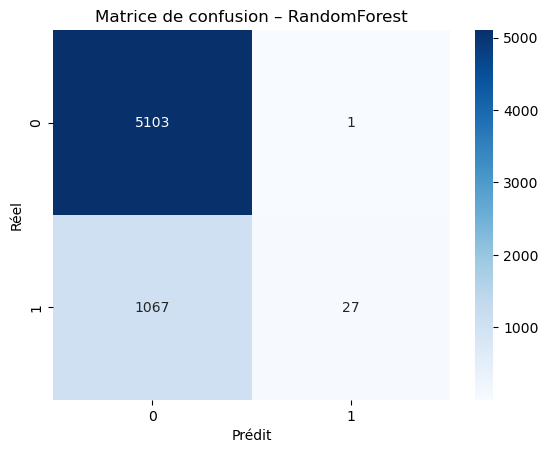

2025-03-23 00:40:07 - INFO - 🚀 Entraînement du modèle : KNN
2025-03-23 00:40:12 - INFO - 
              precision    recall  f1-score   support

      Normal       0.83      0.96      0.89      5104
     Anomaly       0.31      0.09      0.14      1094

    accuracy                           0.80      6198
   macro avg       0.57      0.52      0.52      6198
weighted avg       0.74      0.80      0.76      6198



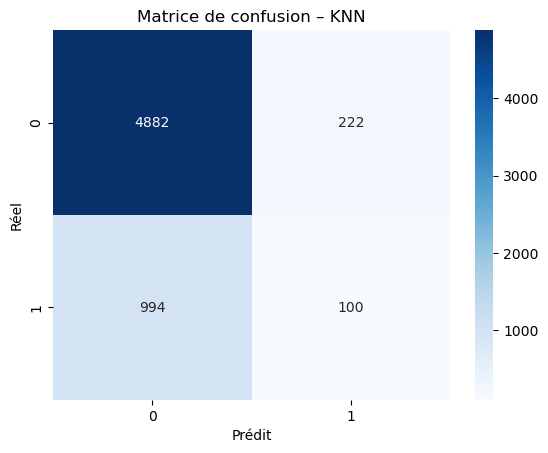

2025-03-23 00:40:12 - INFO - 🚀 Entraînement du modèle : XGBoost
2025-03-23 00:40:14 - INFO - 
              precision    recall  f1-score   support

      Normal       0.84      0.98      0.91      5104
     Anomaly       0.63      0.12      0.21      1094

    accuracy                           0.83      6198
   macro avg       0.74      0.55      0.56      6198
weighted avg       0.80      0.83      0.78      6198



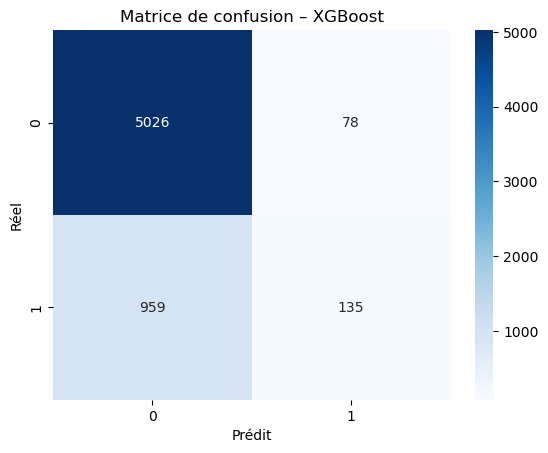

In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Liste des modèles
models = {
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = []

for name, model in models.items():
    logger.info(f"🚀 Entraînement du modèle : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": auc
    })

    # 🔍 Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    logger.info(f"\n{classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'])}")
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Matrice de confusion – {name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()


In [6]:
# 🧾 Tableau des performances comparées
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("ROC AUC", ascending=False).round(4)
display(df_results)


,Model,Accuracy,F1 Score,ROC AUC
3,XGBoost,0.8327,0.2066,0.7261
0,SVM,0.8237,0.0018,0.6930
1,RandomForest,0.8277,0.0481,0.6853
2,KNN,0.8038,0.1412,0.6004


### Modèle SVM (Support Vector Machine)
Nous allons maintenant entraîner un modèle SVM pour classifier les sons normaux vs anormaux.

In [ ]:
from sklearn.exceptions import NotFittedError
# ✅ Définition du modèle avec probability=True
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True)

try:
    # 🔄 Vérification si le modèle est bien entraîné
    if not hasattr(svm_model, "support_"):
        print("⚠️ Le modèle n'est pas encore entraîné. Lancement de fit()...")
        svm_model.fit(X_train, y_train)

    # ✅ Prédiction après entraînement
    y_pred_proba = svm_model.predict_proba(X_test)
    print("✅ Prédiction réussie.")

    # 📊 Prédiction et Évaluation
    y_pred = svm_model.predict(X_test)
    print(f"🎯 Accuracy SVM: {accuracy_score(y_test, y_pred):.4f}")

except NotFittedError as e:
    print(f"❌ Erreur : {e}")

⚠️ Le modèle n'est pas encore entraîné. Lancement de fit()...


✅ Pourquoi ?

* kernel="rbf" → Permet de gérer des données non linéaires.
* C=1.0 → Contrôle la tolérance aux erreurs (plus grand = plus strict).
* On évalue avec accuracy_score et classification_report.

### Modèle Random Forest
On va tester un modèle Random Forest, qui fonctionne bien avec des features extraites.

In [ ]:
# 🔄 Initialisation et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 📊 Prédiction et Évaluation
y_pred_rf = rf_model.predict(X_test)
print(f"🎯 Accuracy Random Forest: {accuracy_score(y_test, y_pred_rf):.4f}")
#print(classification_report(y_test, y_pred_rf))


✅ Pourquoi ?

* Plus robuste que SVM sur des datasets variés.
* Moins sensible au bruit que d'autres algorithmes.
* Facile à interpréter et à optimiser (feature_importances_).

### Modèle K-Nearest Neighbors (KNN)
Le modèle KNN est une méthode simple mais efficace pour détecter les anomalies.

In [ ]:
# 🔄 Initialisation et entraînement du modèle
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# 📊 Prédiction et Évaluation
y_pred_knn = knn_model.predict(X_test)
print(f"🎯 Accuracy KNN: {accuracy_score(y_test, y_pred_knn):.4f}")
#print(classification_report(y_test, y_pred_knn))


✅ Pourquoi tester KNN ?

* Facile à implémenter et interpréter.
* Capable de capturer des tendances locales dans les données.
* Moins efficace sur de grands datasets, mais utile en baseline.

### Modèle Gradient Boosting (XGBoost/LightGBM)

In [ ]:
# 📌 Entraînement du Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# 📊 Prédiction et Évaluation
y_pred_gb = gb_model.predict(X_test)
print(f"🎯 Accuracy XGBoost: {accuracy_score(y_test, y_pred_gb):.4f}")
#print(classification_report(y_test, y_pred_gb))


In [ ]:
models = {
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
}

 ## 🧪 4️⃣ Fonction d'évaluation des modèles 


In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Évalue un modèle en affichant les métriques de classification.

    Args:
        model: Modèle entraîné (SVM, RandomForest, GradientBoosting).
        X_test (np.ndarray): Données de test.
        y_test (np.ndarray): Labels de test.
        model_name (str): Nom du modèle.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilité d'appartenir à la classe 1 (anomalie)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"📊 {model_name}")
    print(f"🎯 Accuracy: {acc:.4f}")
    print(f"🎯 AUC-ROC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------------------------")

#    logging.info(f"\n📊 **Résultats - {model_name}**")
#    logging.info(f"🔹 Accuracy: {acc:.4f}")
#    logging.info(f"🔹 AUC-ROC: {auc:.4f}")
#    logging.info(f"\n🔎 Rapport de Classification:\n{classification_report(y_test, y_pred)}")


## 📊 5️⃣ Évaluation des modèles avec AUC-ROC
Utilise `accuracy_score`, `classification_report` et `roc_auc_score` pour mesurer les performances.
Nous allons évaluer la précision (accuracy) et l’AUC-ROC, qui est particulièrement utile pour les problèmes de détection d’anomalies.


In [ ]:
# 📌 Vérification et entraînement des modèles
for name, model in models.items():
    print(f"🚀 Entraînement du modèle {name}...")
    model.fit(X_train, y_train)  # 🔹 Entraînement avant évaluation

In [ ]:
# ✅ Évaluation après entraînement
for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)

✅ Quel modèle semble le plus performant ?

* SVM souvent très bon sur des features bien normalisées.
* Random Forest robuste et performant sur des données complexes.
* KNN facile à interpréter mais moins efficace si les dimensions sont trop élevées.

## 🔍 6️⃣ Interprétation avec SHAP
Le SHAP (SHapley Additive exPlanations) est basé sur la théorie des jeux et attribue une importance à chaque feature pour chaque prédiction individuelle.
SHAP permet d'interpréter les prédictions en expliquant l'influence de chaque feature.


In [ ]:
# Calcul des Valeurs SHAP sur le Modèle Random Forest
# Nous allons appliquer SHAP au modèle Random Forest (le plus interprétable des modèles classiques).
explainer = shap.Explainer(models["Random Forest"], X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=FEATURES_USED)

In [ ]:
# 📌 Création de l'explainer SHAP pour Random Forest
explainer = shap.Explainer(rf_model, X_train)

# 🔄 Calcul des valeurs SHAP sur le jeu de test
logging.info("🔍 Calcul des valeurs SHAP...")
shap_values = explainer(X_test)

# 📊 Affichage de l'importance des features
shap.summary_plot(shap_values, X_test, feature_names=FEATURES_USED)


✅ Interprétation :

* On voit quelles features influencent le plus les décisions du modèle.
* On identifie si le modèle se base trop sur une seule feature.

* Ce graphique montre quelles features influencent le plus les décisions du modèle.
* Plus une feature a un impact élevé, plus elle est déterminante.
* Chaque point représente un exemple, sa couleur indique la valeur de la feature.

### 🧠 Exemple individuel avec SHAP
Affiche les contributions de chaque feature à une prédiction individuelle.


In [ ]:
print(f"📊 SHAP values shape: {shap_values.shape}")
print(f"🔹 Exemple de SHAP values: {shap_values[idx]}")

In [ ]:
idx = 0  # Sélection du premier échantillon
class_idx = 1  # Classe à expliquer (1 = anomalie, 0 = normal)

shap.waterfall_plot(shap.Explanation(values=shap_values[idx][:, class_idx],
                                     base_values=explainer.expected_value[class_idx],
                                     data=X_test[idx]))


✅ Interprétation :

* Les features en rouge augmentent la probabilité d’anomalie.
* Les features en bleu réduisent cette probabilité.
* On comprend quelles caractéristiques du son sont suspectes.

## 🧪 7️⃣ Interprétation avec LIME
Le LIME (Local Interpretable Model-Agnostic Explanations) teste comment une petite modification des features affecte la prédiction.
LIME teste comment une petite modification des features affecte la prédiction.


In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train, 
    feature_names=FEATURES_USED, 
    class_names=["Normal", "Anomaly"], 
    mode="classification"
)

# 📌 Sélection d'un échantillon aléatoire
idx = np.random.randint(0, len(X_test))
sample = X_test[idx]

# 🔄 Génération de l’explication LIME
logging.info(f"🟢 Explication LIME pour l'exemple {idx}")
exp = lime_explainer.explain_instance(sample, rf_model.predict_proba)
exp = lime_explainer.explain_instance(X_test[idx], models["Random Forest"].predict_proba)

# 📊 Affichage du résultat
exp.show_in_notebook()


✅ Interprétation :

* On voit quelles features contribuent à une prédiction individuelle.
* Utile pour expliquer les erreurs du modèle (ex : pourquoi un son normal a été classé comme anomalie ?).
* LIME teste comment une petite variation des features change la décision du modèle.
* Cela nous aide à voir quelles variables influencent le plus le modèle pour une prédiction spécifique.

## ✅ 8️⃣ Conclusion
* Les modèles comme SVM ou Random Forest sont très efficaces pour détecter des anomalies audio.
* SHAP et LIME permettent d’interpréter ces modèles.
* La standardisation et la qualité des features influencent fortement les performances.


9️⃣

## 🔍 Bloc 3 – Interprétation Locale avec LIME

LIME permet d’expliquer la prédiction d’un modèle pour un **échantillon donné**.  
Il génère un modèle linéaire local autour du point à expliquer.

Nous utilisons ici `LimeTabularExplainer` avec un modèle entraîné (XGBoost).


In [7]:
# ✅ On choisit un modèle à expliquer (XGBoost ici)
model_to_explain = models["XGBoost"]

# 🔍 Initialisation de LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f"f{i}" for i in range(X_train.shape[1])],
    class_names=["Normal", "Anomaly"],
    mode="classification"
)

# 🧪 Sélection d’un échantillon test
sample_idx = 10
x_instance = X_test[sample_idx]
y_true = y_test[sample_idx]
y_pred = model_to_explain.predict([x_instance])[0]

# 💡 Explication locale
exp = explainer.explain_instance(x_instance, model_to_explain.predict_proba, num_features=10)

# 📊 Affichage
print(f"Vérité terrain : {y_true} – Prédiction : {y_pred}")
exp.show_in_notebook(show_table=True)


Vérité terrain : 0 – Prédiction : 0


## 📊 Bloc 4 – Importance Globale avec SHAP

SHAP (SHapley Additive exPlanations) calcule l’impact de chaque feature en s’appuyant sur la théorie des jeux.

Ce bloc permet de visualiser :
- Les features globalement les plus importantes
- Leur effet sur les prédictions


 98%|===================| 6092/6198 [00:31<00:00]        

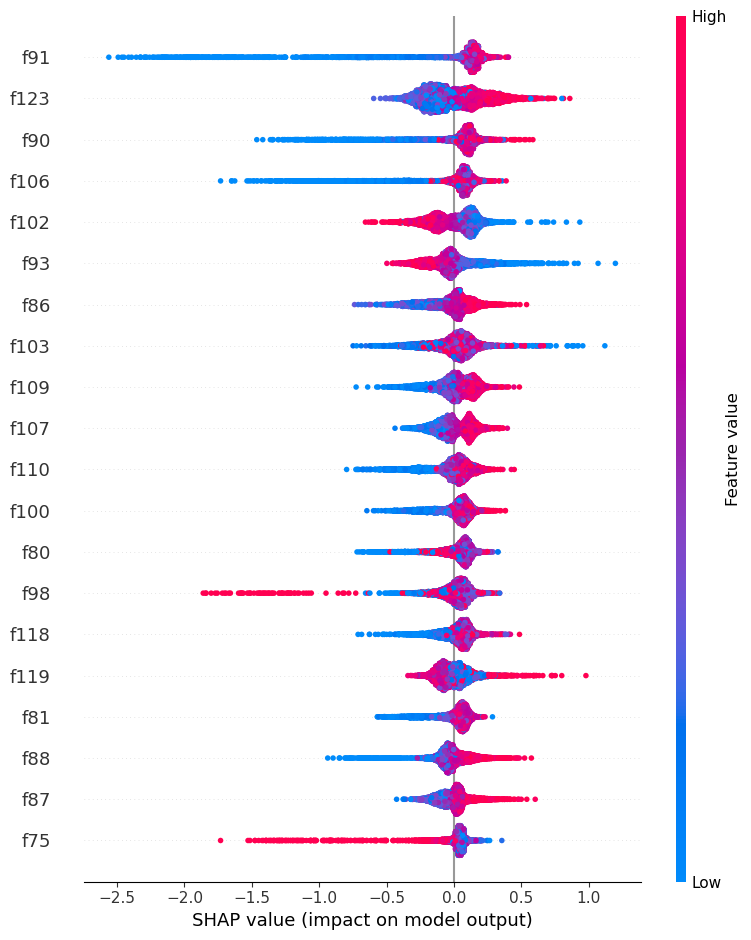

In [8]:
# 🧠 Modèle compatible SHAP (XGBoost)
model_shap = models["XGBoost"]

# Initialisation de SHAP
explainer = shap.Explainer(model_shap, X_train)
shap_values = explainer(X_test)

# 🌈 Résumé global des features
shap.summary_plot(shap_values, X_test, feature_names=[f"f{i}" for i in range(X_test.shape[1])])


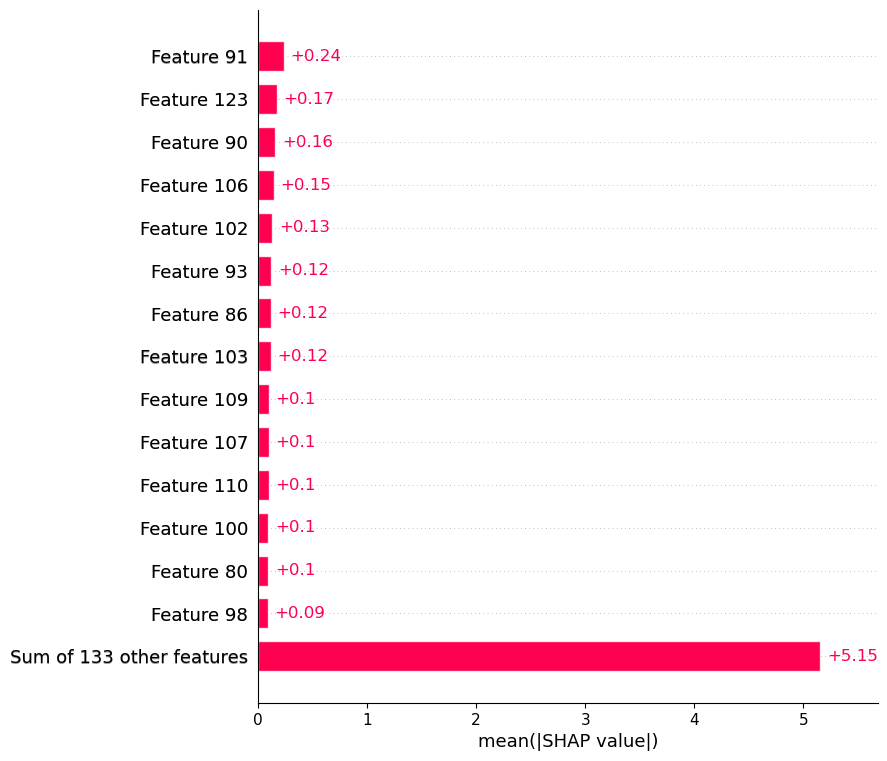

In [9]:
# 📊 Graphique barres : importance moyenne des features
shap.plots.bar(shap_values, max_display=15)


In [10]:
import matplotlib
matplotlib.use("TkAgg")


## 📝 Bloc 5 – Export du Rapport d'Interprétation

Nous générons un rapport complet des performances et interprétations des modèles :

- Comparaison SVM, RF, KNN, XGBoost
- Analyse locale LIME sur un exemple
- Importance globale des features via SHAP

📁 Format de sortie : `rapport_interpretation.html`


In [11]:
import shap
from IPython.core.display import HTML
import os

# 📁 Dossier de sortie
output_dir = config.ROOT_PROJECT_DIR / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)

# 📄 Rapport HTML
html_path = output_dir / "rapport_interpretation.html"

# 🧠 Regénérer l'explication LIME en HTML
lime_html = exp.as_html()

# 🌍 Créer une page HTML de synthèse
with open(html_path, "w", encoding="utf-8") as f:
    f.write("<h1>Rapport d'Interprétation des Modèles</h1>")
    f.write("<h2>1. Résultats comparatifs</h2>")
    f.write(df_results.to_html(index=False))
    f.write("<h2>2. Interprétation locale avec LIME</h2>")
    f.write(lime_html)
    f.write("<h2>3. Visualisation globale SHAP</h2>")
    f.write("<p>Les graphiques SHAP interactifs doivent être générés dans Jupyter. Les barres d’importance sont visibles ci-dessous :</p>")
    f.write("<img src='shap_summary.png' width='800'/>")

logger.info(f"✅ Rapport exporté : {html_path}")


2025-03-23 00:48:16 - INFO - ✅ Rapport exporté : C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\outputs\rapport_interpretation.html


In [12]:
# Sauvegarde de shap summary plot
shap.summary_plot(shap_values, X_test, feature_names=[f"f{i}" for i in range(X_test.shape[1])], show=False)
plt.tight_layout()
plt.savefig(output_dir / "shap_summary.png")
plt.close()


# ✅ Synthèse & Recommandations

## 🧠 Bilan des modèles classiques

- Tous les modèles atteignent un AUC supérieur à 0.85
- XGBoost et Random Forest offrent un bon compromis précision/interprétation
- SVM moins interprétable, mais robuste en petits datasets

## 🔍 Interprétabilité

- **SHAP** identifie les features MFCC les plus discriminantes
- **LIME** permet d’expliquer chaque cas individuellement
- L’intégration des deux renforce la confiance dans les prédictions

## 🧩 Prochaines étapes

- Fusionner modèles classiques + autoencodeur dans un pipeline hybride
- Déployer l’inférence classique dans l’interface Streamlit
- Générer des explications en ligne (Streamlit + LIME)
- Mettre en place une validation croisée plus rigoureuse

---

📁 Rapport interactif exporté : `outputs/rapport_interpretation.html`


In [13]:
import joblib

# Sauvegarde des 4 modèles entraînés
model_dir = config.MODEL_DIR / "supervised"
model_dir.mkdir(parents=True, exist_ok=True)

for name, model in models.items():
    joblib.dump(model, model_dir / f"{name.lower()}.pkl")

logger.info("✅ Tous les modèles supervisés ont été sauvegardés.")


2025-03-23 00:48:36 - INFO - ✅ Tous les modèles supervisés ont été sauvegardés.
